In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

# CHARGER LE DATASET

In [2]:
df = pd.read_csv("C:/Users/sylva/OneDrive/Bureau/Deep_Learning_Hetic_2023/Projet_deep_learning_covid/datset_depat2.csv", sep=";")
df

,semaine,reg,pop,P,T,Ti,Tp,Td
0,29/05/2020,1,376879,111,3659,"29,45","3,03","970,87"
1,29/05/2020,2,358749,68,4272,"18,95","1,59","1190,8"
2,29/05/2020,3,290691,827,7500,"284,49","11,03","2580,06"
3,29/05/2020,4,859959,267,13544,"31,05","1,97","1574,96"
4,29/05/2020,5,5997,0,55,0,0,"917,13"
...,...,...,...,...,...,...,...,...
15489,17/04/2023,93,2062499,9760,58765,"473,21","16,61","2849,21"
15490,17/04/2023,94,162314,519,2555,"319,75","20,31","1574,11"
15491,17/04/2023,94,162314,735,3460,"452,83","21,24","2131,67"
15492,17/04/2023,94,187151,505,2446,"269,84","20,65","1306,97"


# Ce code permet d' INDEXER la colonne [semaine] dans LE Dataset

In [3]:

df["semaine"] = pd.to_datetime(df["semaine"])
df.set_index("semaine", inplace=True)
df.head()

,reg,pop,P,T,Ti,Tp,Td
semaine,,,,,,,
2020-05-29,1,376879,111,3659,"29,45","3,03","970,87"
2020-05-29,2,358749,68,4272,"18,95","1,59","1190,8"
2020-05-29,3,290691,827,7500,"284,49","11,03","2580,06"
2020-05-29,4,859959,267,13544,"31,05","1,97","1574,96"
2020-05-29,5,5997,0,55,0,0,"917,13"


# Nous avons procéder à la Suppression  des colonnes [TI] [TP] [TD]

In [4]:
df.drop(columns=["T", 'Tp','Td'], inplace=True)
df.head()

,reg,pop,P,Ti
semaine,,,,
2020-05-29,1,376879,111,"29,45"
2020-05-29,2,358749,68,"18,95"
2020-05-29,3,290691,827,"284,49"
2020-05-29,4,859959,267,"31,05"
2020-05-29,5,5997,0,0


# Nous avons utiliser la methode . describe() pour afficher l'écart type (std), La Moyenne (mean) et le minimum (min) 

In [5]:
df.describe()

,reg,pop,P
count,15494.000000,1.549400e+04,15494.000000
mean,51.331031,6.472985e+05,2443.877049
std,28.833062,5.157200e+05,5676.712491
min,1.000000,5.997000e+03,0.000000
25%,27.000000,2.783600e+05,188.000000
50%,52.000000,5.059205e+05,727.500000
75%,76.000000,8.284050e+05,2336.500000
max,94.000000,2.606873e+06,110120.000000


# Data Preprocessing

# ETAPES

In [6]:
df

,reg,pop,P,Ti
semaine,,,,
2020-05-29,1,376879,111,"29,45"
2020-05-29,2,358749,68,"18,95"
2020-05-29,3,290691,827,"284,49"
2020-05-29,4,859959,267,"31,05"
2020-05-29,5,5997,0,0
...,...,...,...,...
2023-04-17,93,2062499,9760,"473,21"
2023-04-17,94,162314,519,"319,75"
2023-04-17,94,162314,735,"452,83"


# Nous avons modifier les occurences (",") en (".") dans La Colonne Ti de notre dataframe

In [7]:
df['Ti'] = df['Ti'].str.replace(',', '.')
df

,reg,pop,P,Ti
semaine,,,,
2020-05-29,1,376879,111,29.45
2020-05-29,2,358749,68,18.95
2020-05-29,3,290691,827,284.49
2020-05-29,4,859959,267,31.05
2020-05-29,5,5997,0,0
...,...,...,...,...
2023-04-17,93,2062499,9760,473.21
2023-04-17,94,162314,519,319.75
2023-04-17,94,162314,735,452.83


# Nous avons transformé les données de la colonne Ti (chaine de caractère)en données numériques pour faciliter la lecture et le calcule

In [8]:
df['Ti'] = pd.to_numeric(df['Ti'])

In [9]:
df['Ti']

semaine
2020-05-29     29.45
2020-05-29     18.95
2020-05-29    284.49
2020-05-29     31.05
2020-05-29      0.00
               ...  
2023-04-17    473.21
2023-04-17    319.75
2023-04-17    452.83
2023-04-17    269.84
2023-04-17    362.81
Name: Ti, Length: 15494, dtype: float64

# Nous avons extrait la valeur maximale dans notre Dataframe en utilisant la méthode .values.max(), puis calculé un point de séparation split à 80% de la longueur totale du DataFrame.

In [10]:
max = df.values.max()
split = int(len(df)*0.8)
print(max, split)

2606873.0 12395



# Nous avons divisé les données de notre DataFrame en deux ensembles entraînement: (train) et (test). Les valeurs de ces ensembles sont normalisées en les divisant par la valeur maximale (max) obtenue précédemment.

In [11]:
train = df[:split].values / max
test = df[split:].values / max


# Nous avons crée 2 générateurs de séquences (train_generator et test_generator) à partir (train) et (test) avec une longueur de séquence (input_length) de 4 et une taille de batch (batch_size) de 1.

In [12]:
input_length = 4
features_length = 1
train_generator = TimeseriesGenerator(train, train, length=input_length, batch_size=1)
test_generator = TimeseriesGenerator(test, test, length=input_length, batch_size=1)

# Nous avons extrait la première séquence d'entraînement (x) et sa valeur cible correspondante (y) à partir du générateur de séquences d'entraînement (train_generator[0]).Puis nous avons afficher les dimensions de (x) et (y) par print(x.shape) et print(y.shape).
# RESULTAT : nous avons obtenu comme sortie (1, 4, 4) (1, 4) interprétée comme suite : (1, 4, 4) signifie tableau tridimensionnel avec batch_size 1, longueur de séquence 4 et 4 caractéristiques. (1, 4) signifie batch_size 1 et longueur de séquence de 4.

In [13]:
x, y = train_generator[0]
print(x.shape)
print(y.shape)

(1, 4, 4)
(1, 4)


 # Nous avons extrait la longueur de séquence (input_length) et la longueur des caractéristiques (features_length) à partir des dimensions de x, première séquence d'entraînement. x.shape[1] renvoie la deuxième dimension de x (la longueur de séquence), et x.shape[2] renvoie la troisième dimension de x (la longueur des caractéristiques).

In [14]:
input_length = x.shape[1]
features_length = x.shape[2]

# Couche d'entrée (InputLayer) avec une forme d'entrée input_length et features_length. Une couche LSTM avec 50 unités, une fonction d'activation tangente hyperbolique ("tanh") pour les activations et une activation récurrente sigmoide ("sigmoid"), sans retour de séquence. Une couche de (Dropout) avec un taux de 0.3 pour régulariser le modèle.(Dense) avec sigmoid pour la sortie finale avec un nombre d'unités correspondant à features_length. Un optimiseur Adam avec un taux d'apprentissage de 0.005. la fonction de perte ("mse" pour l'erreur quadratique moyenne) et les métriques d'évaluation ("mae" pour l'erreur absolue moyenne). 
# Résultat : nombre total de paramètres (11 204) et nombre de paramètres entraînables (11 204).

In [15]:
lstm_model = Sequential()

lstm_model.add(InputLayer(input_shape=(input_length, features_length)))
lstm_model.add(LSTM(50, activation="tanh", recurrent_activation="sigmoid", return_sequences=False))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(features_length, activation="sigmoid"))

optmizer = tf.keras.optimizers.Adam(learning_rate=0.005)

lstm_model.compile(optimizer=optmizer, loss="mse", metrics=["mae"])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 11,204
Trainable params: 11,204
Non-trainable params: 0
_________________________________________________________________


# la fonction "scheduler" pour définir une stratégie d'ajustement du taux d'apprentissage pendant l'entraînement d'un modèle d'apprentissage automatique en le décroissant progressivement à chaque epochs à l'aide de l'exponentielle de -0.2.

In [16]:
def scheduler(epoch, lr):
  return lr*tf.math.exp(-0.2)

# Ce code permet d'ajuster le taux d'apprentissage définie par la fonction "scheduler" à chaque époque de l'entraînement. S'il n'ya pas démélioration dans la perte de validation ("val_loss"), "early_stopping" restaure les meilleurs poids pour éviter le overfitting

In [17]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Dans l'entrainement du modele, nous avons utilisé 19 époques d'entraînement et appliquer un ajustement dynamique du (learning_rate_scheduler) et arrêter l'entraînement (early_stopping) en cas de stagnation de la performance. L'historique d'apprentissage est stocké dans la variable history, qui contient les métriques de performance (perte, métriques) à chaque époque d'entraînement.

In [18]:
history = lstm_model.fit(train_generator, epochs=19, validation_data=test_generator,callbacks=[learning_rate_scheduler, early_stopping], verbose=1)

Epoch 1/19
12391/12391 [==============================] - 50s 4ms/step - loss: 0.0076 - mae: 0.0337 - val_loss: 0.0048 - val_mae: 0.0229 - lr: 0.0041
Epoch 2/19
12391/12391 [==============================] - 47s 4ms/step - loss: 0.0049 - mae: 0.0240 - val_loss: 0.0045 - val_mae: 0.0219 - lr: 0.0034
Epoch 3/19
12391/12391 [==============================] - 47s 4ms/step - loss: 0.0043 - mae: 0.0222 - val_loss: 0.0042 - val_mae: 0.0210 - lr: 0.0027
Epoch 4/19
12391/12391 [==============================] - 47s 4ms/step - loss: 0.0040 - mae: 0.0212 - val_loss: 0.0039 - val_mae: 0.0202 - lr: 0.0022
Epoch 5/19
12391/12391 [==============================] - 45s 4ms/step - loss: 0.0037 - mae: 0.0200 - val_loss: 0.0037 - val_mae: 0.0195 - lr: 0.0018
Epoch 6/19
12391/12391 [==============================] - 46s 4ms/step - loss: 0.0034 - mae: 0.0189 - val_loss: 0.0034 - val_mae: 0.0181 - lr: 0.0015
Epoch 7/19
12391/12391 [==============================] - 47s 4ms/step - loss: 0.0031 - mae: 0.0180 

# Nous affichons enssuite le premier batch générées par le générateur pour visualiser les données d'entrée et de sortie qui seront utilisées pour évaluer la performance du modèle sur les données de test.

In [19]:
print(test_generator[0])

(array([[[9.20643238e-06, 2.32224585e-01, 6.76672780e-04, 1.11777597e-04],
        [9.20643238e-06, 2.61957525e-01, 6.67082746e-04, 9.76840836e-05],
        [1.03572364e-05, 5.37598111e-02, 1.37329283e-04, 9.79909647e-05],
        [1.03572364e-05, 7.65652949e-02, 2.89235417e-04, 1.44909246e-04]]]), array([[1.03572364e-05, 8.94535330e-02, 1.68400992e-04, 7.22167900e-05]]))


# Nous avons extrait la valeur de (val_loss) à partir de l'historique d'apprentissage, et stocké cette valeur dans la variable y_true pour ensuite l'utiliser.

In [32]:
y_true = history.history['val_loss'] 

# Nous avons crée une séquence de nombres allant de 0 à la longueur de la variable y_true, et stocke cette séquence dans la variable time_steps.

In [33]:
time_steps = range(0, len(y_true))
# time2_steps = range(0, len(y_pred))

# Nous avons fait une réprésentation graphique grace à la fonction "plt.plot()des variables "time_steps" et "y_true". "time_steps" représente X, et "y_true" : Y.

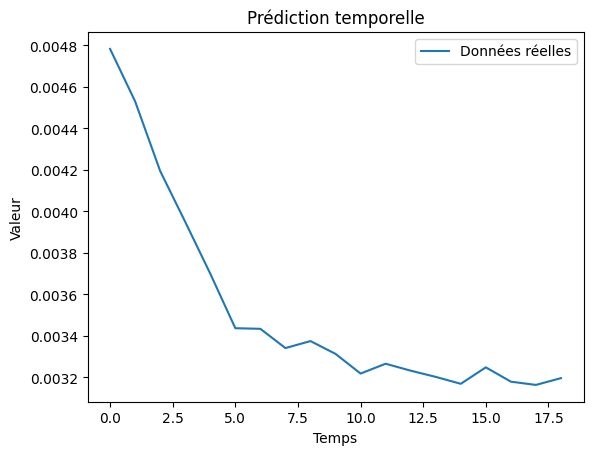

In [22]:
# Tracé des données réelles et prédites

plt.plot(time_steps,y_true, label='Données réelles')

# Personnalisation du graphique
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.title('Prédiction temporelle')
plt.legend()

# # Affichage du graphique
plt.show()


# Notre graphique est courbe représentative de notre prédiction temporelle des données réelles sur l'évolution de la propagation du covid. En Abscisse c'est le temps qui représente la période sur laquelle repose notre prédiction. A cha epoch nous constatons une mise à jour par raport à l'epoch passé? En ordonnée, c'est la valeur à prédire (Y_pred). Nous constatons une décroissance de la courbe par la fonction (scheduler) à chaque épochs, parce que à chaque entrainement du modele, la valeur du y_pred est récupéré et utilisé à chaque itération dans l'Historique dans laquelle elle est stockée. Cette intervalle des valeurs du time_steps

In [23]:
import plotly.graph_objects as go

In [24]:
fig = go.Figure(data=[go.Scatter3d( 
    x=x[:, 0].flatten(),
    y=x[:, 1].flatten(),
    z=y.flatten(),
    
    mode='lines',
    line=dict(
        color=y.flatten(),
        colorscale='YlGn',
        reversescale=True,
        width=3
    )
)])

fig.update_layout(template= "plotly_dark", margin=dict(l=0, r=0, b=0, t=0))
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [25]:
# git checkout ma-branche    #mise à jour

# git add nom_du_fichier.py

# git push origin ma-branche



# git add .
# git commit -m "Votre message de commit"

# git push origin master



